In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import stats
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
import pdb

In [24]:
curr_dir = '/user_data/vayzenbe/GitHub_Repos/ginn'
study_dir = f'/lab_data/behrmannlab/scratch/vlad/ginn/fmri/pixar'
subj_dir = f'{study_dir}/derivatives/preprocessed_data'
ts_dir = f'{study_dir}/derivatives/timeseries'
model_dir = f"/lab_data/behrmannlab/vlad/ginn/modelling/model_ts"
results_dir = f"{curr_dir}/results/mean"

sub_info = pd.read_csv(f'{curr_dir}/fmri/pixar-sub-info.csv')

leave_out = .2
vols = 168
fix_tr =5 #first 5 volumes of the scan (10 s) were fix in the beginning

AgeGroup = ['3yo', '4yo', '5yo','7yo','8-12yo','Adult']
#AgeGroup = ['Preschooler', 'Adult']
#AgeGroup = ['3yo', 'Adult']


roi= ['lLO','rLO', 'lFFA', 'rFFA', 'lA1','rA1']




train_cond = ['imagenet_noface', 'imagenet_oneface', 'imagenet_vggface',  'vggface', 'random']
fig_cond =  ['imagenet_noface', 'imagenet_oneface', 'imagenet_vggface',  'vggface', 'random']
model_type = 'sl'
layer =['pIT', 'pIT', 'aIT', 'aIT','pIT', 'pIT', 'aIT', 'aIT']
layer =['aIT', 'aIT', 'aIT', 'aIT']
layer = 'aIT'
epochs = [0,1, 5, 10, 15, 20, 25, 30]
vid = 'partly_cloudy'


#train_cond = ['general']
#n_classes = [600]
#train_cond = ['imagenet_objects']
#model_types = ['vggface']


print(sub_info['AgeGroup'].value_counts())


#sub_info.loc[sub_info['AgeGroup'].isin(['3yo', '4yo']), 'AgeGroup'] = 'Preschooler'
#sub_info

5yo       34
8-12yo    34
Adult     33
7yo       23
3yo       17
4yo       14
Name: AgeGroup, dtype: int64


In [25]:
'''
Load all participants in an age group
'''

def data_by_age(age,rr):
    
    
    #   curr_sub = sub_info.loc[sub_info['AgeGroup'].isin(age)]
    #else:
    curr_sub = sub_info[sub_info['AgeGroup'] == age]
    

    all_data = np.zeros((len(curr_sub), vols))
    for sn, ss in enumerate(curr_sub['participant_id']):
        temp = np.loadtxt(f'{subj_dir}/{ss}/timeseries/{rr}_ts_mean.txt')
        temp = (temp - np.mean(temp))/np.std(temp) # standardize the unit activations
        all_data[sn,:] = temp

    all_data = all_data[:,fix_tr:] # get rid of the first n volumes of rest

    #li = len(all_data) * (1-leave_out)
    #li = int(np.round(li,0))

    #train_ts = np.mean(all_data[0:li,:], axis = 0)
    #test_ts = np.mean(all_data[li:,:], axis =0)
    
    return all_data

In [23]:
def plot_fit(summary_df,metric='fit', noise_ceil=True, save=False, filename=None, fig_cond=train_cond):
    
    test = summary_df.pivot_table(columns = "model", index = 'age')
    

    x = np.arange(len(AgeGroup))  # the label locations
    width = .15  # the width of the bars

    colors = pl.cm.RdBu(np.flip(np.linspace(.1,.9,len(train_cond))))
    #colors = pl.cm.magma(np.linspace(0,.9,len(train_cond)))
    fig, ax = plt.subplots(figsize=(11,5))
    offset =  [-2,-1,0,1,2]
    n = 0
    for tcn, tc in enumerate(train_cond):
        #epochs = list(summary_df['epoch'][summary_df['model'] == tc])
        #print(epochs)
        loc = x + (offset[tcn]*(width))
        ax.bar(loc, test[metric][tc], width, label = fig_cond[tcn], color = colors[n],edgecolor="black")
        #labels = ax.bar(loc, epochs, width)
        
        
        #ax.text(loc, .8, s='0', ha='center', va='bottom')
        ax.errorbar(loc, test[metric][tc], yerr =test[f'{metric}_se'][tc]  ,color='black',linestyle='none')
        
        if noise_ceil== True:
            
            ax.plot(loc, test['noise_ceil'][tc], color='black', marker='o', linestyle='none')
        

        n +=1
    plt.title(f'{layer} layer fits to {rr}')
    ax.axhline(0, color='black')
    ax.set_xticks(x)
    ax.set_xticklabels(AgeGroup)
    ax.set_ylabel('Correlation', size = 13)
    ax.set_xlabel('Age', size = 13)
    ax.set_facecolor("white")
    ax.tick_params(axis='x', colors='black',width =2, labelsize=12)
    ax.tick_params(axis='y', colors='black',width =2, labelsize=12)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    
    for spine in ['bottom','left']:
        ax.spines[spine].set_color('black')
        ax.spines[spine].set_linewidth(2)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.ylim([-.2,1])
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Models")

    if save == True:
        plt.savefig(f'{results_dir}/figures/{filename}.jpg',bbox_inches='tight', dpi = 300)
        


In [18]:
'''
Grab best epoch for each model
'''
def find_best(summary_df):

    best_models = pd.DataFrame(columns = ['age', 'model', 'epoch','noise_ceil','noise_ceil_se', 'fit', 'fit_se'])
    for tc in train_cond:
        for age in AgeGroup:
            temp_df = summary_df[(summary_df['model'] == tc) & (summary_df['age']  == age)]
            #temp_df = summary_df[(summary_df['model'] == tc) & (sub_info['AgeGroup'].isin(age))]
            temp_df = temp_df[temp_df['fit'] == np.max(temp_df['fit'])]
            best_models = best_models.append(temp_df)


    

    return best_models


In [19]:
'''
Caluclate norm for each group
'''

def norm_data(best_models):
    best_models['norm']  = (best_models['fit'])/(best_models['noise_ceil'])
    best_models['norm_se'] = (best_models['fit_se'])/(best_models['noise_ceil'])

    #plot_fit(best_models, 'norm', noise_ceil=False,save=True, filename=f'{vid}_{model_type}_{rr}_normed.png', fig_cond=fig_cond)
        
    return best_models

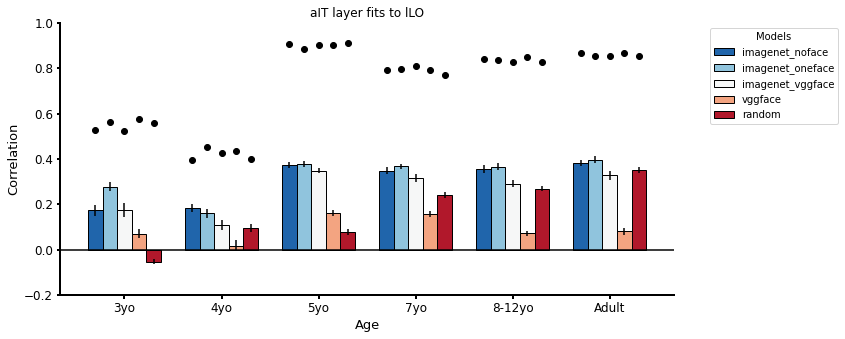

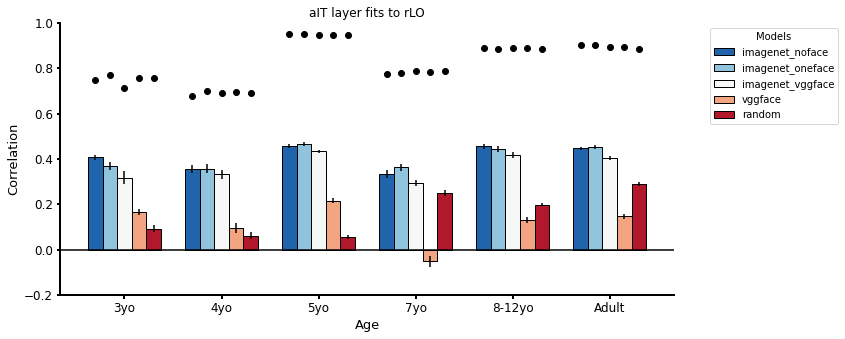

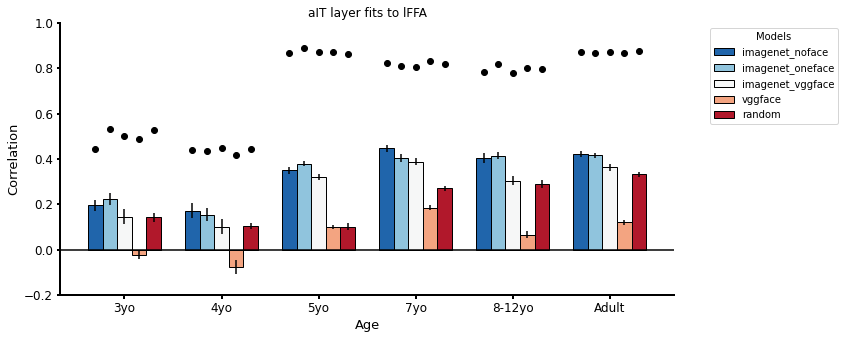

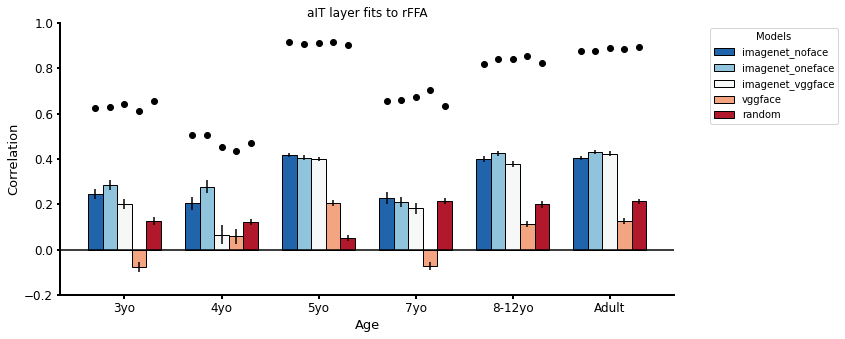

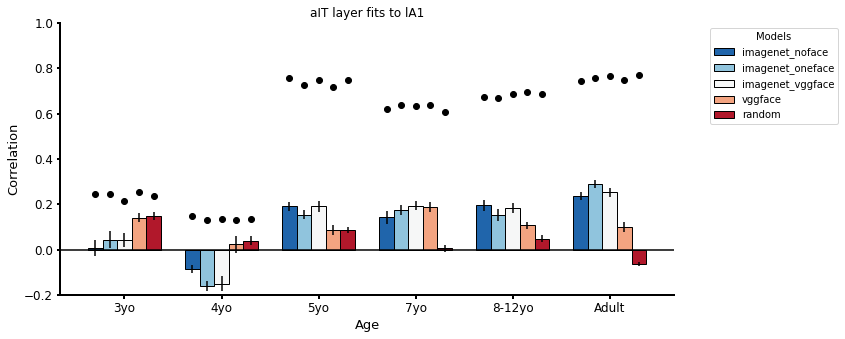

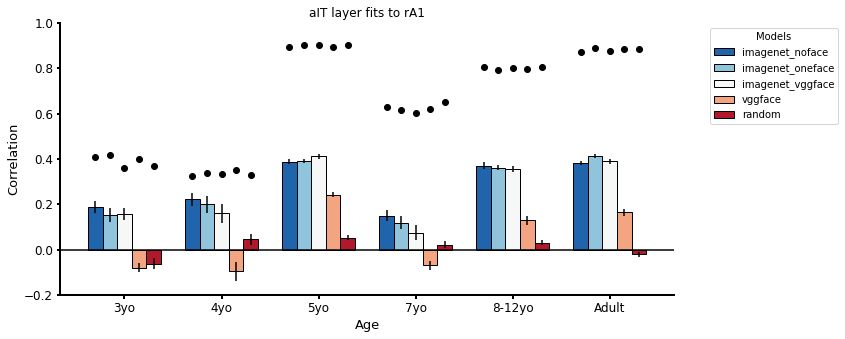

In [32]:
#set up cross val
shss = ShuffleSplit(n_splits=30, test_size=.20)


for rn, rr in enumerate(roi):
    summary_df = pd.DataFrame(columns = ['age', 'model', 'noise_ceil','noise_ceil_se', 'fit', 'fit_se'])
    for age in AgeGroup:
        age_data = data_by_age(age,rr)
        for tc in train_cond:
        

            model_ts = np.load(f'{model_dir}/cornet_z_{model_type}_{tc}_{layer}_{vid}_ts.npy')
            
            model_ts = model_ts[:,0:1]#model_ts[0:90,:]

            pred = []
            noise_ceil = []
            n = 0
            for train_ind, test_ind in shss.split(age_data):
                train, test = age_data[train_ind,:], age_data[test_ind,:]
                train = np.mean(train, axis = 0)
                test = np.mean(test, axis = 0)

                clf = Ridge(normalize=True) #how to best to choose regularization term?
                clf.fit(model_ts, train, )
                pred_ts = clf.predict(model_ts)
                pred.append(stats.pearsonr(pred_ts,test)[0])
                noise_ceil.append(stats.pearsonr(train, test)[0])
                n+= 1                   


            temp_df = pd.Series([age, tc, np.mean(noise_ceil), stats.sem(noise_ceil), np.mean(pred), stats.sem(pred)],index = summary_df.columns)
            summary_df = summary_df.append(temp_df, ignore_index = True)
            #if tc == 'random':
            #    break
                    
    #best_model = find_best(summary_df)
    plot_fit(summary_df,metric='fit', noise_ceil=True, save=False, filename=f'{vid}_{model_type}_{rr}', fig_cond=fig_cond)
    #print(best_model)
    #best_model = norm_data(best_model)

                #print(model_ts.shape, train.shape)



                #pred_ts = clf.predict(model_ts)


            #print(age, stats.pearsonr(train, test)[0]**2,tc, pred_ts)
                #print(age,stats.pearsonr(train, test)[0], tc, stats.pearsonr(pred_ts, test)[0])


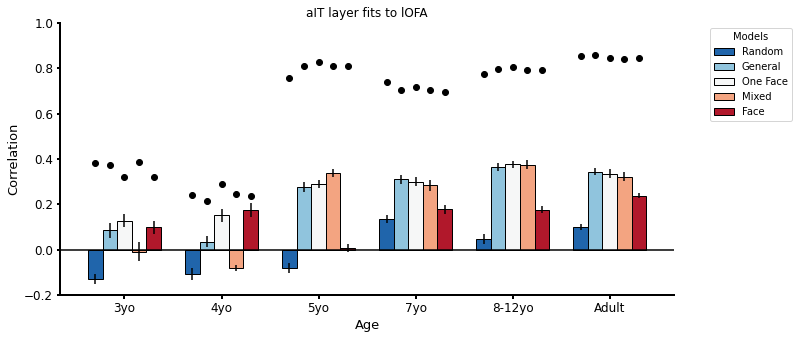

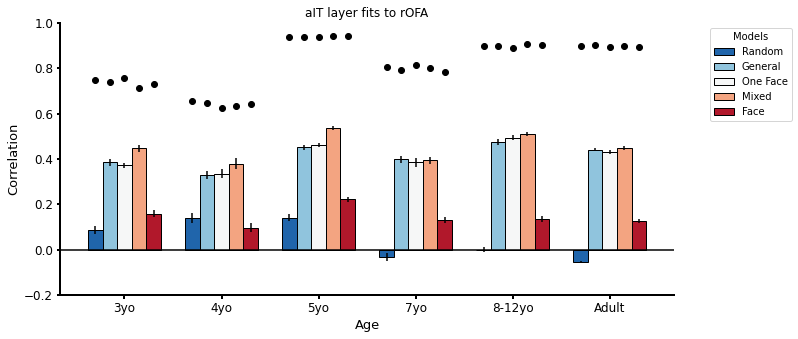

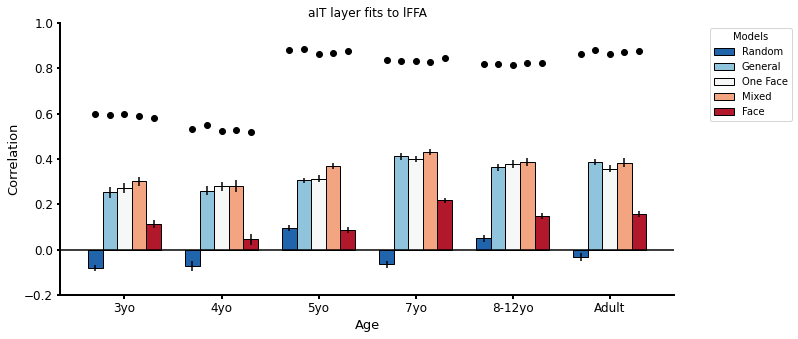

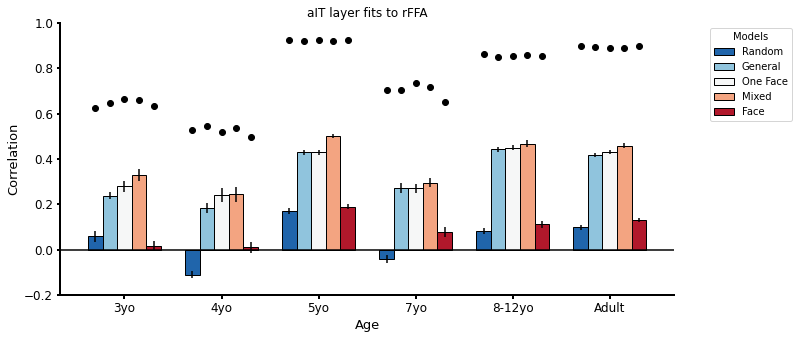

In [12]:
#set up cross val
shss = ShuffleSplit(n_splits=30, test_size=.20)


for rn, rr in enumerate(roi):
    summary_df = pd.DataFrame(columns = ['age', 'model', 'epoch','noise_ceil','noise_ceil_se', 'fit', 'fit_se'])
    for age in AgeGroup:
        age_data = data_by_age(age,rr)
        for tc in train_cond:
            for ee in epochs:

                model_ts = np.load(f'{results_dir}/{vid}_{model_type}_{tc}_{ee}_{layer[rn]}_TS.npy')
                model_ts[0:90,:]

                pred = []
                noise_ceil = []
                n = 0
                for train_ind, test_ind in shss.split(age_data):
                    train, test = age_data[train_ind,:], age_data[test_ind,:]
                    train = np.mean(train, axis = 0)
                    test = np.mean(test, axis = 0)

                    clf = Ridge(normalize=True) #how to best to choose regularization term?
                    clf.fit(model_ts, train, )
                    pred_ts = clf.predict(model_ts)
                    pred.append(stats.pearsonr(pred_ts,test)[0])
                    noise_ceil.append(stats.pearsonr(train, test)[0])
                    n+= 1                   


                temp_df = pd.Series([age, tc, ee, np.mean(noise_ceil), stats.sem(noise_ceil), np.mean(pred), stats.sem(pred)],index = summary_df.columns)
                summary_df = summary_df.append(temp_df, ignore_index = True)
                if tc == 'random':
                    break
                    
    best_model = find_best(summary_df)
    plot_fit(best_model,metric='fit', noise_ceil=True, save=True, filename=f'{vid}_{model_type}_{rr}', fig_cond=fig_cond)
    #print(best_model)
    #best_model = norm_data(best_model)

                #print(model_ts.shape, train.shape)



                #pred_ts = clf.predict(model_ts)


            #print(age, stats.pearsonr(train, test)[0]**2,tc, pred_ts)
                #print(age,stats.pearsonr(train, test)[0], tc, stats.pearsonr(pred_ts, test)[0])


In [13]:
test = preschool.pivot_table(columns = "model", index = 'age')
test

NameError: name 'preschool' is not defined

In [ ]:
'''
calculate individual differences
'''

roi = ['FFA']
for rn, rr in enumerate(roi): #Loop through ROIs
    for tc in train_cond[3:3]: #loops through models
        age_df = pd.DataFrame(columns = ['age', 'model', 'epoch','fit'])
        for sn, ss in enumerate(sub_info['participant_id']): #for each participant calcualte the model fit
            temp = np.loadtxt(f'{ts_dir}/{ss}_{rr}_timecourse.txt')
            temp = (temp - np.mean(temp))/np.std(temp) # standardize the unit activations
            temp = temp[fix_tr:] #cut first few fixation TRs
            indiv_df = pd.DataFrame(columns = ['age', 'model', 'epoch','fit'])
            pred = []
            for ee in epochs[1:]: #Test all epochs and find best epoch

                model_ts = np.load(f'{results_dir}/{vid}_{model_type}_{tc}_{ee}_{layer[rn]}_TS.npy')
                clf = Ridge(normalize=True) #how to best to choose regularization term?
                clf.fit(model_ts, temp)
                pred_ts = clf.predict(model_ts)
                pred = stats.pearsonr(pred_ts,temp)[0]

                temp_df = pd.Series([sub_info['Age'][sn], tc, ee, pred],index = age_df.columns)
                indiv_df = indiv_df.append(temp_df, ignore_index = True)

            indiv_df = indiv_df[indiv_df['fit'] == np.max(indiv_df['fit'])]
            age_df = age_df.append(indiv_df)
        
        print(rr, tc)
        plt.scatter(age_df['age'], age_df['fit'])
            
    
    
            
                    
                    

                




In [ ]:
test = best_models.pivot_table(columns = "model", index = 'age')
test['epoch']['vggface']

In [ ]:
sub_info

In [ ]:
'''
something something fit of the general model vs. face as a function age
Maybe fit proportion general/(face + general) x age
'''

